In [1]:
import torch
from AmazonDataset import CustomDataset_Test
from pathlib import Path
import numpy as np
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser
import json
import imageio
from osgeo import gdal
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import GiovConfig as giov_config
from prep_giov_data import prep4dataset_test
from GiovanniDataset import GiovanniDataset
from metrics_amazon import f1_score, Precision, Recall, ACC, precision_recall_curve
import os

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
work_dirs_path = Path(
    '/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs'
)
# work_dirs = os.listdir(work_dirs_path)
work_dirs = ['custom_exp01_All', 'custom_exp02_Pop', 'custom_exp03_Precip', 'custom_exp04_PastDef', 'custom_exp05_NightL']
experiments_data = {'custom_exp01_All': [True, True, True, True], 'custom_exp02_Pop': [False, True, True, True],\
    'custom_exp03_Precip': [True, False, True, True], 'custom_exp04_PastDef': [True, True, False, True],\
    'custom_exp05_NightL': [True, True, True, False]}

inputs_shape = [2, 1, 1, 2] 

In [3]:
res = {}
for work_dir in work_dirs:
    EX_NAME = work_dir
    exp_data = experiments_data[EX_NAME]
    # root_dir = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches')
    img_path = Path('/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/test.tif')
    exp_path = Path(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/{EX_NAME}')
    
    # preds = np.argmax(np.load(exp_path / 'saved' / 'preds.npy'), axis=2)
    labels = np.load(exp_path / 'saved' / 'trues.npy')
    logits = np.load(exp_path / 'saved' / 'preds.npy')
    print(logits.shape)
    # preds = F.softmax(torch.Tensor(logits), dim=2).numpy()
    # preds = F.sigmoid(torch.Tensor(logits)).numpy()
    preds = (logits >= 0.5)
    print('DEBUG Probs vs Logits')
    print(logits.max(), logits.min())
    print(preds.max(), preds.min())
    # trues = np.load(exp_path / 'saved' / 'trues.npy')

    # preds0 = preds[:, :, 0]
    # preds1 = preds[:, :, 1]
    # preds1 = preds[:, :, 0]
    # preds_argmax = np.argmax(preds, axis=2)
    preds0 = logits
    preds1 = logits
    preds_argmax = preds
    # th = 0.55
    # preds_argmax = preds1.copy()
    # preds_argmax[preds1 >= th] = 1
    # preds_argmax[preds1 < th] = 0

    f1_0, f1_1 = f1_score(preds_argmax, labels, test_time=True)
    prec = Precision(preds_argmax, labels)
    recall = Recall(preds_argmax, labels)
    acc = ACC(preds_argmax, labels)
    f1_scre = 2 * prec * recall / (prec + recall)
    print(f'F1-score: {f1_scre:.4f} - F1-score No Def: {f1_0:.4f} - F1-score Def: {f1_1:.4f} - Precision: {prec:.4f} - Recall: {recall:.4f} - Accuracy: {acc:.4f}')

    # Recall = def_metrics[:, 0]
    # Precision = def_metrics[:, 1]

    # Calculate precision-recall curve
    # thresholds = list(np.arange(0, 1.05, 0.05))
    thresholds = list(np.arange(logits.min(), logits.max(), 0.05))
    precision, recall, thresholds = precision_recall_curve(thresholds, labels.reshape(-1), preds1.reshape(-1))

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Find the threshold that maximizes the F1 score
    opt_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[opt_idx]
    opt_f1 = f1_scores[opt_idx]
    opt_prec = precision[opt_idx]
    opt_recall = recall[opt_idx]
    print(f'Optimal Threshold: {optimal_threshold:.4f} - F1-score: {opt_f1:.4f} - Precision: {opt_prec:.4f} - Recall: {opt_recall:.4f}')
    res[EX_NAME] = [optimal_threshold, opt_f1]
    
    # Plot precision-recall curve
    # plt.plot(recall, precision, label='Precision-Recall Curve')
    # plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.legend()
    # plt.show()

    preds_argmax = preds1.copy()
    preds_argmax[preds1 >= optimal_threshold] = 1
    preds_argmax[preds1 < optimal_threshold] = 0

    f1_0, f1_1 = f1_score(preds_argmax, labels, test_time=True)
    prec = Precision(preds_argmax, labels)
    recall = Recall(preds_argmax, labels)
    acc = ACC(preds_argmax, labels)
    f1_scre = 2 * prec * recall / (prec + recall)
    print(f'F1-score: {f1_scre:.4f} - F1-score No Def: {f1_0:.4f} - F1-score Def: {f1_1:.4f} - Precision: {prec:.4f} - Recall: {recall:.4f} - Accuracy: {acc:.4f}')

    #TODO: Save metrics in a csv
    # print(f"Optimal Threshold: {optimal_threshold:.2f}")
        
    # Plot the histograms side by side
    plt.figure(figsize=(5, 5))

    # plt.subplot(1, 2, 1)
    plt.hist(preds0.reshape(-1), bins=20, range=(logits.min(), logits.max()), edgecolor='black', alpha=0.7)
    plt.title('No def Probs')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')

    # plt.subplot(1, 2, 2)
    # plt.hist(preds1.reshape(-1), bins=10, range=(0, 1), edgecolor='black', alpha=0.7)
    # plt.title('Def Probs')
    # # plt.xlabel('Value')
    # # plt.ylabel('Frequency')

    plt.tight_layout()
    # Save the figure with 300 DPI
    plt.savefig(exp_path / 'saved' / 'classes_probs_hist.jpeg', dpi=300)
    plt.show()

(2760, 1, 1, 64, 64)
DEBUG Probs vs Logits
7.8356466 -15.435934
True False

[[11113063    39951]
 [  149785     2161]]
F1-score: 0.9915 - F1-score No Def: 0.9915 - F1-score Def: 0.0223 - Precision: 0.9867 - Recall: 0.9964 - Accuracy: 0.9832


PrecisionxRecall:  36%|███▌      | 168/466 [00:22<00:39,  7.55it/s]


KeyboardInterrupt: 

In [5]:
res

{'custom_exp01_All': [0.21406593322776146, 0.03295867344601869],
 'custom_exp02_Pop': [1.6290691375732287, 0.07672011361045504],
 'custom_exp03_Precip': [0.4958812713624319, 0.04734355035581505],
 'custom_exp04_PastDef': [0.46245365142819495, 0.06132122868987577],
 'custom_exp05_NightL': [1.3096884727477907, 0.07634609343587749]}

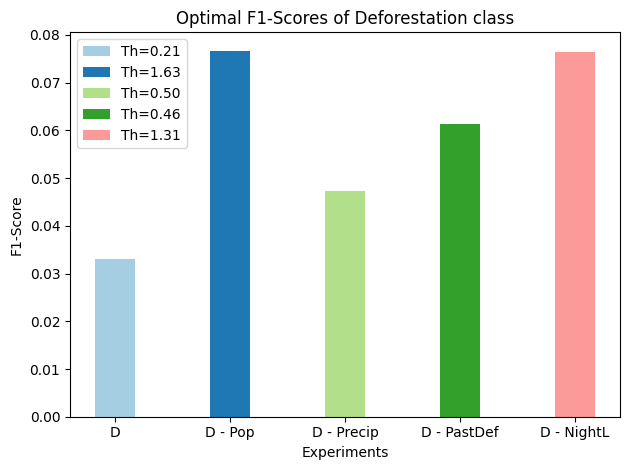

In [4]:
import matplotlib.pyplot as plt
import numpy as np

data = {'D': [0.21406593322776146, 0.03295867344601869],
        'D - Pop': [1.6290691375732287, 0.07672011361045504],
        'D - Precip': [0.4958812713624319, 0.04734355035581505],
        'D - PastDef': [0.46245365142819495, 0.06132122868987577],
        'D - NightL': [1.3096884727477907, 0.07634609343587749]}

labels = list(data.keys())
thresholds = [item[0] for item in data.values()]
values2 = [item[1] for item in data.values()]

bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99']  # Softer colors
bars = ax.bar(index, values2, bar_width, color=colors)

ax.set_xlabel('Experiments')
ax.set_ylabel('F1-Score')
ax.set_title('Optimal F1-Scores of Deforestation class')
ax.set_xticks(index)
ax.set_xticklabels(labels)

# Add threshold values to the legend at the top left
legend_labels = [f'Th={threshold:.2f}' for threshold in thresholds]
ax.legend(bars, legend_labels)

plt.tight_layout()
plt.show()
fig.savefig('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/feature_comp.jpg', dpi=300, bbox_inches='tight')
